In [1]:
import numpy as np
import gymnasium as gym
from envs import ForbiddenAreaCfg, RewardCfg
from common.grid_world import Policy, get_return

env = gym.make(
    "envs:gridworld-v0",
    forbidden_area_cfg=ForbiddenAreaCfg(num=6),
    reward_cfg=RewardCfg(forbidden_area=-10),
)

# MC Basic

In [2]:
policy = Policy(env)
episode_length = 30
num_episodes = 1  # due to grid world is deterministic, we only need one episode to get the expected q value.
k = 10
gamma = 0.9

size = env.unwrapped.size
states = [(i, j) for i in range(size[0]) for j in range(size[1])]

In [3]:
for _ in range(k):
    for s in states:
        q_values = np.empty(5)
        for a in range(5):  # 0: up, 1: right, 2: down, 3: left, 4: stay
            # get enough return to estimate the expected q value
            q = np.array(
                [
                    get_return(s, a, env, policy, episode_length)
                    for _ in range(num_episodes)
                ]
            )
            q_values[a] = q.mean(dtype=np.float32)
        policy.improve(s, q_values)

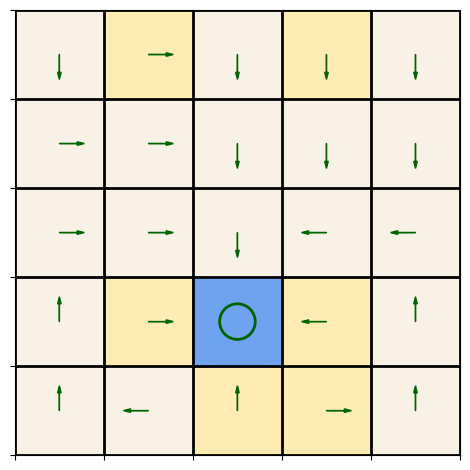

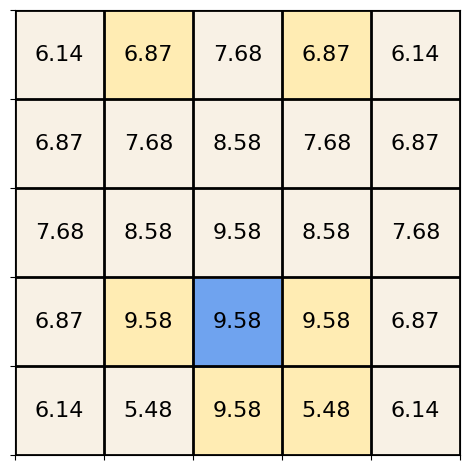

In [4]:
from common.grid_world import Visualizer

vis = Visualizer(env)
vis.draw_strategy(policy)
vis.draw_state_values(policy, episode_length, num_episodes)